In [57]:
from lspi.basis_functions import ExactBasis, RadialBasisFunction
from lspi.policy import Policy
from lspi.policy_ct import QuadraticPolicy
from lspi.sample import Sample
from lspi.solvers import LSTDQSolver
import lspi
from lspi import domains
import os
import numpy as np

In [58]:

domain = lspi.domains.ChainDomain()

sampling_policy = lspi.Policy(lspi.basis_functions.DummyBasis(2), .9, 1)

samples = []
for i in range(1000):
    action = sampling_policy.select_action(domain.current_state())
    samples.append(domain.apply_action(action))

random_policy_cum_rewards = np.sum([sample.reward
                                            for sample in samples])

solver = lspi.solvers.LSTDQSolver()


# initial_policy = lspi.Policy(
#             lspi.basis_functions.RadialBasisFunction(
#                 np.array([[0], [2], [4], [6], [8]]), .5, 2),
#             .9,
#             0)

initial_policy = lspi.Policy(
            lspi.basis_functions.OneDimensionalPolynomialBasis(3, 2),
            .9,
            0)


learned_policy = lspi.learn(samples, initial_policy, solver)

domain.reset()
cumulative_reward = 0
for i in range(1000):
    action = learned_policy.select_action(domain.current_state())
    sample = domain.apply_action(action)
    cumulative_reward += sample.reward

cumulative_reward, random_policy_cum_rewards

i=1 Distance: 12.383239289250248
i=2 Distance: 2.357380603370795
i=3 Distance: 2.114404674338345
i=4 Distance: 0.0


(906, np.int64(238))

In [60]:

from data_processing import *
ssar = np.load("ssar.npy")
# ssar = np.unique(ssar,axis = 0)
n_action = 1
n_state = 2

# exit(0)
samples = load_from_data(ssar, n_state, n_action)

solver = LSTDQSolver()
policy, all_policies = lspi_loop_offline(solver, samples, discount=0.8, epsilon=0.01, max_iterations=1)


Number of basis functions: 6
Number of basis functions: 6
Number of basis functions: 6
*********************************************************
LSPI iteration: 1
Number of basis functions: 6
i=1 Distance: 4.687409589824059, Hf, Huu: [0.20460674], [[0.46383075]]
i=2 Distance: 0.009295080248781333, Hf, Huu: [0.00158681], [[0.00819071]]
Norms -> Lmax: 3.621722   L2: 4.695834
Number of basis functions: 6


In [46]:
folder_path = "/Users/xinyi/Documents/Data/ossur/DC_04_26"
params = np.load(os.path.join(folder_path, "params.npy"))
states = []
for i in range(len(params)):
    state = np.load(os.path.join(folder_path, f"state_{i}.npy"))
    states.append(state)

# slice based on params:
slice_params = np.array([63, -1, 41])
slice_id = slice_params > 0
print("slicing params based on: ", slice_params)
mask = np.all(params[:, slice_id] == slice_params[slice_id], axis=1)
params = params[mask][:, ~slice_id]

states = [states[i] for i in range(len(states)) if mask[i]]
n_state, n_action = states[0].shape[1], params.shape[1]

scale_s, offset_s, scale_a, offset_a = np.load( "scale_s.npy"), np.load("offset_s.npy"), np.load("scale_a.npy"), np.load("offset_a.npy")

# Convert weights to state-action space
print(convertW2S(policy.weights))
np.save("policy_weights.npy", policy.weights) 

# check if the policy makes sense
# create pseudo samples as the group mean of different param sets.
pseudo_samples = []
for i in range(len(states)):
    state = states[i].mean(axis=0) - np.array([60, 0.66])
    state = (state - offset_s)/scale_s[0]
    print(policy.best_action(state))
    policy_action = (policy.best_action(state) + offset_a) * scale_a
    
    print(f"param set {i}: {params[i]}, state: {state}, action: {policy_action}")

pseudo_samples = np.array(pseudo_samples)


slicing params based on:  [63 -1 41]
[[-3.73237932 -2.57307433 -0.00401013]
 [-2.57307433 -3.76632805 -0.09315282]
 [-0.00401013 -0.09315282 -0.1388949 ]]
[1.]
param set 0: [16.], state: [ 1.3598055  -0.00798753], action: [-14.15538666]
[-1.]
param set 1: [40.], state: [-1.06212258e+00  5.96800402e-04], action: [-69.44986581]
[-1.]
param set 2: [64.], state: [-0.31477542  0.00687129], action: [-69.44986581]


In [4]:
from mpl_toolkits.mplot3d import Axes3D

# print file name in dir plot:
# for f in os.listdir('./plot'):
comb = []
for f in os.listdir('/Users/xinyi/Documents/Data/ossur/DC_04_26/'):
    if f.endswith('.csv'):
        # print(f)
        comb.append([float(s) for s in f.split('.')[0].split('_')])
comb = np.array(comb)

comb


array([[75., 64., 41.],
       [75., 40., 41.],
       [63., 16., 80.],
       [63., 16., 41.],
       [69., 16., 41.],
       [69., 16., 80.],
       [63., 64., 80.],
       [63., 40., 80.],
       [63., 40., 41.],
       [63., 64., 41.],
       [69., 64., 41.],
       [69., 40., 41.],
       [69., 40., 80.],
       [69., 64., 80.]])

Note: you may need to restart the kernel to use updated packages.


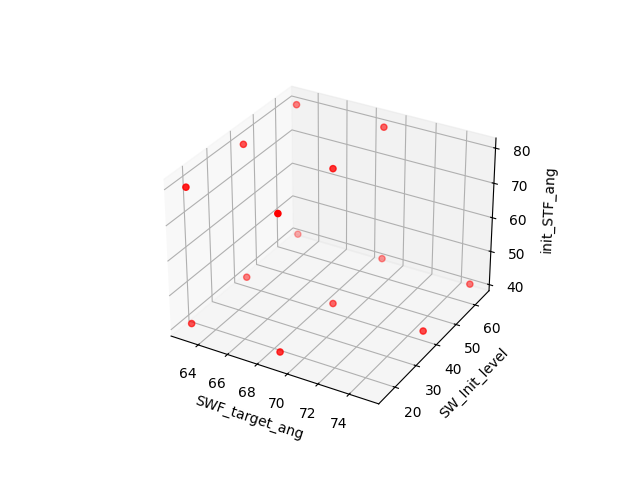

In [5]:
%pip install ipympl
%matplotlib widget
import matplotlib.pyplot as plt

# visualize comb in an interactive 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(comb[:, 0], comb[:, 1], comb[:, 2], c='r', marker='o')

ax.set_xlabel("SWF_target_ang")
ax.set_ylabel("SW_Init_level")
ax.set_zlabel("init_STF_ang")  # Ensure z-label is displayed

plt.show()

In [6]:
ssar = np.load("ssar.npy")
ssar.shape
n_action = 3
n_state = 2

ws = np.load("policy_weights.npy")
policy = QuadraticPolicy(n_action=  n_action, n_state=n_state, weights=ws, discount=0.8, explore=0.01)
print(policy.num_actions,"*"*30)


Number of basis functions: 15


ValueError: weights shape must equal (basis.size(), 1)

In [ ]:
state = np.array([0.5, 0.5])
ba = policy.best_action(state)

# policy.calc_q_value(np.array([0.001, 0.002]), 0)

In [ ]:
from scipy.optimize import minimize
Huu, Hf = policy.extract_qp_parameters(state) 
print(Huu)
print(Hf)
action = ba
- 0.5 * action[None,:] @ Huu @ action[:,None] - Hf @ action[:,None],ba

[[-1.6859199   0.12965365 -0.25696255]
 [ 0.12965365 -2.83037714  0.35717911]
 [-0.25696255  0.35717911 -2.42530402]]
[ 0.42519156 -0.18192113 -0.07485596]


(array([[4.74685257]]), array([-1.,  1., -1.]))

In [ ]:

# Solve constrained optimization
res = minimize(
    fun=lambda a: 0.5 * a[None,:] @ Huu @ a[:,None] + Hf @ a[:,None], 
    x0=np.zeros((policy.n_action,)),
    bounds=[(-.5, .5)], # for a N(0,1) distribution, it is reasonable to set the bounds to (-3, 3), because 99.7% of the values will fall within this range
    # method = 'Nelder-Mead',
    # method = 'L-BFGS-B',
    # method = 'TNC',
    method = 'trust-constr',
    # constraints={'type': 'ineq', 'fun': lambda a: A @ a - Ax}
)
res.x

array([-0.49989044,  0.49991307, -0.49988914])

In [ ]:
# policy.basis.evaluate(np.array([0.005, 0.002]), np.array([0,0,0]))
policy.calc_q_value(np.array([0.5, 0.5]), np.array([-1,1,-1]))

array([[4.74685257]])

In [ ]:
for i in (1, -1):
    for j in (1, -1):
        for k in (1, -1):
            print(policy.calc_q_value(np.array([0.5, 0.5]), np.array([i, j, k])))
    

[[3.07251585]]
[[3.12323705]]
[[3.68233909]]
[[2.30434387]]
[[3.66828118]]
[[4.74685257]]
[[3.75948983]]
[[3.4093448]]


array([[-1.05535757,  0.14252026, -1.05535757,  0.14252026, -0.01980647,
        -0.5568898 ],
       [-1.05535757,  0.14252026, -0.32110357,  1.16857589,  0.8413443 ,
        -0.5568898 ],
       [-1.05535757,  0.14252026,  1.32413951, -1.26125916, -0.88095724,
        -0.5568898 ],
       [-0.32110357,  1.16857589, -1.05535757,  0.14252026, -0.88095724,
        -0.05155375],
       [-0.32110357,  1.16857589, -0.32110357,  1.16857589, -0.01980647,
        -0.05155375],
       [-0.32110357,  1.16857589,  1.32413951, -1.26125916, -1.74210801,
        -0.05155375],
       [ 1.32413951, -1.26125916, -1.05535757,  0.14252026,  0.8413443 ,
        -0.87667273],
       [ 1.32413951, -1.26125916, -0.32110357,  1.16857589,  1.70249507,
        -0.87667273],
       [ 1.32413951, -1.26125916,  1.32413951, -1.26125916, -0.01980647,
        -0.87667273]])